In [1]:
%cd ..

/Users/marko/Economic_Networks


In [1]:
%pwd

'/Users/marko/Economic_Networks/notebooks'

We want a shocking regime that will allow for higher orders - simulateAll. Exponential decay on the next orders of the shock. I.e. if we have dz in the beginning - look at the simulate one time code and add exponential decaying values of the previous dz. Multiply by some constant less than one to the initial shock to the result of the y - economically, the pandemic did not just happen in a week, and these effects are more or less there. so dz initially -> dz at next step plus some constant times dz. 

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import quandl
import seaborn as sns
import yfinance as yf

from datetime import datetime
from IPython.core.display import Image, display
from itertools import combinations
from matplotlib import animation
from econnet import data
from econnet import simulator

In [4]:
# Set plotting font sizes and properties
TINY_SIZE = 12
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
mpl.rcParams["figure.dpi"] = 180 # sets the image quality

# Height and width per row and column of subplots
FIG_HEIGHT = 18
FIG_WIDTH = 16
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("Paired")

# Ideas for Industry Mappings to Equities

Below, I list the industries overlapping in the H matrix and the other matrix Tzu looked at for determining dz and possible equity names we can use to estimate dz and compare with his approach. 

| Industry Name | Description | Possible Equities |
| --- | --- | --- |
| Truck Transportation | Provide transportation of cargo using motor vehicles, such as trucks and tractor trailers. | S&P Transportation Select Industry Index, Dow Jones Transportation Average |
| Utilities | Provide basic amenities - water, electricity, dams, and natural gas. | Dow Jones Utility Average, Utilities Select Sector SPDR Fund |
| Pipeline transportation | Use transmission pipelines to transport products like crude oil and natural gas  | Producer Price index (not an equity though),  |
| Construction | Engaged in construction of buildings or engineering projects  | Dow Jones U.S. Construction & Materials Index, iShares U.S. Home Construction ETF |
| Rail transportation | Provide rail transportation of passengers and/or cargo using railroad rolling stock. | S&P 500 Road & Rail Industry Index, Producer Price Index |
| Hospitals | Provide medical, diagnostic, and treatment services that include physician, nursing, and other health services. | S&P 500 Health Care, Dow Jones U.S. Health Care Index |
| Accommodation | Part of the leisure and hospitality supersector. | DJUSLG (hotels index), HLT (Hilton stock) |
| Farms | Provides large-scale, intensive production of crops and animals. | S&P GSCI Agriculture, Dow Jones U.S. Farming & Fishing Total Stock Market Index |
| Machinery | Produces and maintains machines for consumers. | Dow Jones U.S. Industrial Machinery Index |
| Chemical products | Produce industrial chemicals. | Dow Jones U.S. Chemicals Index |
| Educational services | Provide instruction and training in a wide variety of subjects. | S&P 1500 Education Services Sub-Industry Index |
| Water transportation | Provide water transportation of passengers and cargo using watercraft, such as ships, barges, and boats. | Producer Price Index, Invesco S&P Global Water Index ETF (CGW) |
| General Government | Includes production by all Federal, state, and local government agencies except for government enterprises. | No Clue |
| Air transportation | Provide air transportation of passengers and/or cargo using aircraft, such as airplanes and helicopters. | S&P 500 Airlines Industry Index, Dow Jones U.S. Airlines Index |
| Real estate | Consists of the sale of land and improvements, which include buildings, fixtures, roads, structures, and utility systems | Dow Jones U.S. Real Estate Index, Real Estate Select Sector |
| Housing | Not sure how this is different from above. | PHLX Housing Index, U.S. NAHB Housing Market Index |
| Legal services | Includes establishments that provide paralegal, notary public, process serving, and patent agent services. | Producer Price Index |
| Other retail | Includes establishments primarily engaged in retailing specialized lines of merchandise (except motor vehicle and parts dealers; furniture and home furnishings stores; electronic and appliance stores; building material and garden equipment and supplies dealers; food and beverage stores; health and personal care stores; gasoline stations; clothing and clothing accessories stores; sporting goods, hobby, book and music stores; general merchandise stores; florists; office supplies, stationery and gift stores; used merchandise stores; pet and pet supplies stores; art dealers; manufactured home (i.e., mobile homes) dealers; and tobacco stores) | No Clue |
| Wholesale trade | Comprises establishments engaged in wholesaling merchandise, generally without transformation, and rendering services incidental to the sale of merchandise. | No Clue |
| Social assistance | Provides help to individuals and families to aid them in becoming healthy and productive members of society. | No Clue |
| Mining | Consists of the search for, extraction, beneficiation, and processing of naturally occurring solid minerals from the earth. | S&P Metals & Mining Select Industry Index, Dow Jones U.S. Mining Index |
| Primary metals | Smelt and/or refine ferrous and nonferrous metals from ore, pig or scrap, using electrometallurgical and other process metallurgical techniques. | Producer Price Index |



# Creating the equity index matrix

In [5]:
# reading in the equity data
df = pd.read_csv('data/equities/Download Data - FUND_US_ARCX_CGW.csv')[["Date", "Close"]]
df_dim = len(df["Date"])
df = df.rename(columns={"Close": "Water transportation"})
df["Housing"] = pd.read_csv('data/equities/Download Data - INDEX_US_XNAS_HGX.csv')["Close"].values

# this is missing one - I just add the same value to the end of the pandas series
farms_series = pd.read_csv('data/equities/Download Data - INDEX_XX_S&P GSCI_SPGSAG.csv')["Close"].values 
df["Farms"] = np.append(farms_series, farms_series[-1:])

# these have an extra date for some reason - so I decide to remove the last ones 
# that are not included in the series
df["Truck transportation"] = pd.read_csv('data/equities/Download Data - INDEX_US__DJT.csv')["Close"].values[:df_dim] 
df["Utilities"] = pd.read_csv('data/equities/Download Data - INDEX_US__DJU.csv')["Close"].values[:df_dim]
df["Accommodation"] = pd.read_csv('data/equities/Download Data - INDEX_XX_DOW JONES GLOBAL_DJUSLG.csv')["Close"].values[:df_dim]
df["Chemical products"] = pd.read_csv('data/equities/Download Data - INDEX_XX_DOW JONES WILSHIRE_DWCCHM.csv')["Close"].values[:df_dim]
df["Construction"] = pd.read_csv('data/equities/Download Data - INDEX_XX_DOW JONES WILSHIRE_DWCCNS.csv')["Close"].values[:df_dim]
df["Machinery"] = pd.read_csv('data/equities/Download Data - INDEX_XX_DOW JONES WILSHIRE_DWCIDE.csv')["Close"].values[:df_dim]
df["Mining"] = pd.read_csv('data/equities/Download Data - INDEX_XX_DOW JONES WILSHIRE_DWCMIN.csv')["Close"].values[:df_dim]
df["Real estate"] = pd.read_csv('data/equities/Download Data - INDEX_XX_DOW JONES WILSHIRE_DWCRHD.csv')["Close"].values[:df_dim]
df["Educational services"] = pd.read_csv('data/equities/Download Data - INDEX_XX_S&P US_SP1500.25302010.csv')["Close"].values[:df_dim]
df["Air transportation"] = pd.read_csv('data/equities/Download Data - INDEX_XX_S&P US_SP500.203020.csv')["Close"].values[:df_dim]
df["Rail transportation"] = pd.read_csv('data/equities/Download Data - INDEX_XX_S&P US_SP500.203040.csv')["Close"].values[:df_dim]
df["Hospitals"] = pd.read_csv('data/equities/Download Data - INDEX_XX_S&P US_SP500.351020.csv')["Close"].values[:df_dim]
df["Date"] = [datetime.strptime(date, '%m/%d/%Y') for date in list(df["Date"].values)]
df.index = df["Date"].values
df = df.drop(columns=["Date"])

# some columns are strings :(
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if type(df.iloc[i, j]) != np.float64:
            df.iloc[i, j] = float((df.iloc[i, j].replace(',', '')))

In [6]:
df.head()

,Water transportation,Housing,Farms,Truck transportation,Utilities,Accomodation,Chemical products,Construction,Machinery,Mining,Real estate,Educational services,Air transportation,Rail transportation,Hospitals
2020-12-31,46.80,390.91,367.63,12506.93,864.64,2203.07,8106.25,10078.81,18598.99,1505.43,5984.29,55.75,229.10,2401.38,1133.15
2020-12-30,46.83,394.21,363.87,12459.23,850.59,2181.17,8067.05,10050.31,18462.04,1519.17,6011.18,55.20,231.50,2380.67,1116.76
2020-12-29,46.71,391.78,357.49,12429.48,848.89,2143.16,7970.23,9946.29,18254.46,1493.01,6007.39,54.72,228.58,2362.89,1121.48
2020-12-28,46.54,395.33,351.65,12524.02,849.55,2140.69,7999.88,10042.28,18421.56,1496.32,6124.78,56.45,229.43,2383.73,1119.03
2020-12-24,46.33,400.72,352.90,12522.92,845.97,2138.39,8028.48,10069.9,18495.48,1509.93,6082.8,56.53,227.60,2366.34,1107.34


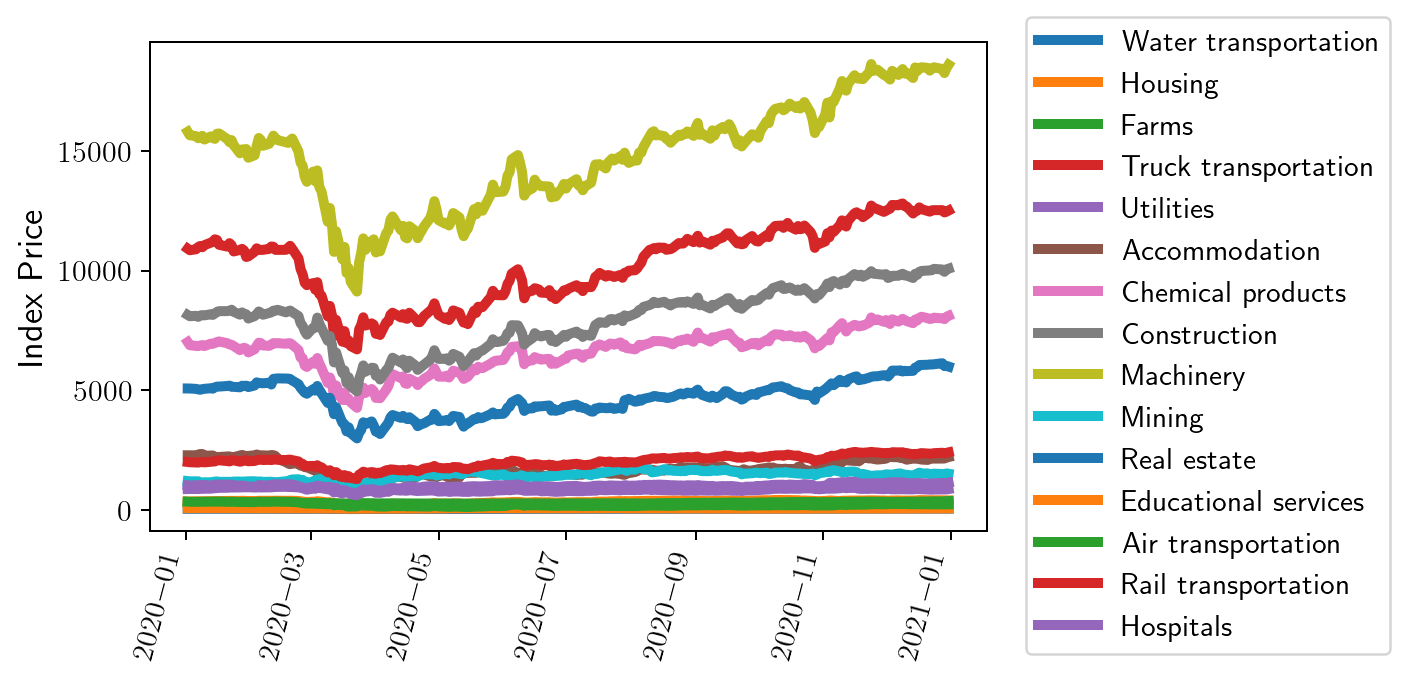

In [6]:
df.plot()
plt.xticks(rotation=75)
plt.legend(loc='upper right')
plt.ylabel('Index Price')
plt.legend(bbox_to_anchor=(1.5,0.4), loc="center right")
plt.show()

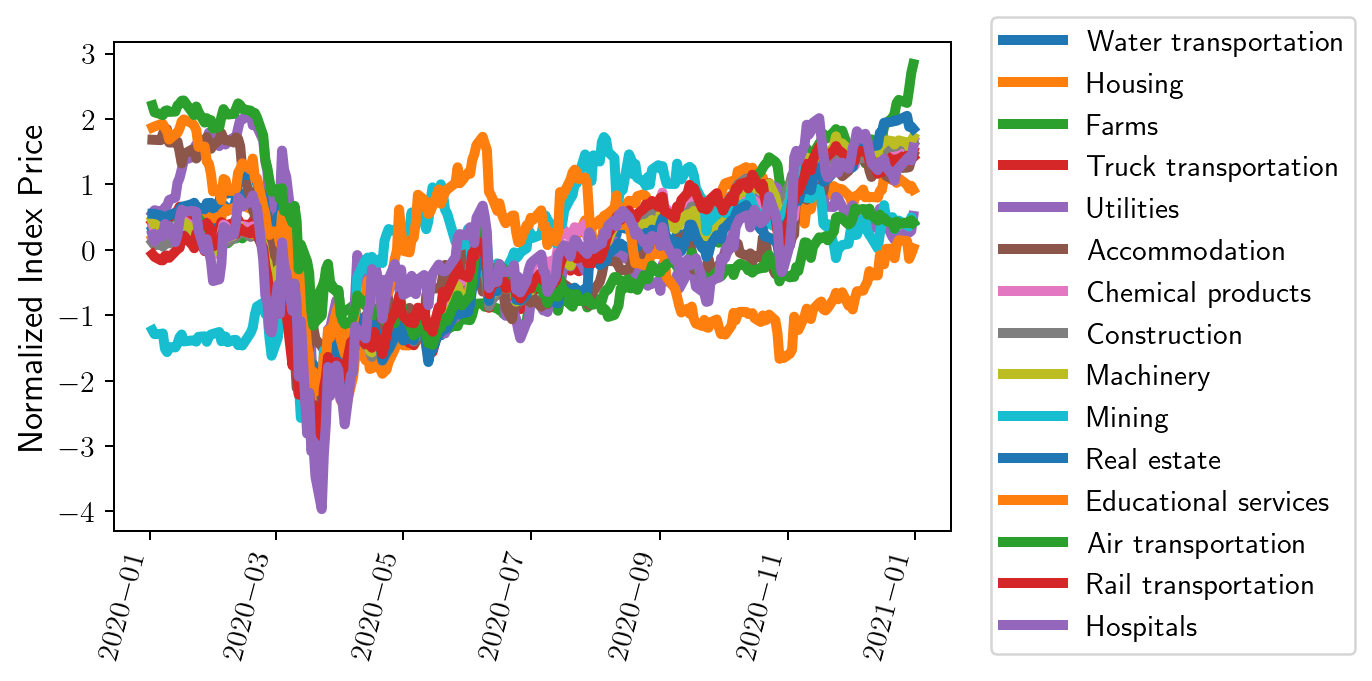

In [8]:
df.apply(lambda x: (x - x.mean()) / x.std(), axis=0).plot()
plt.xticks(rotation=75)
plt.legend(loc='upper right')
plt.ylabel('Normalized Index Price')
plt.legend(bbox_to_anchor=(1.5,0.4), loc="center right")
plt.show()

In [15]:
year = 2020
H = data.I2IReqs(year).make_adjacency()

def rolling_sub(x):
    return (x.iloc[-1] - x.iloc[0]) / x.iloc[0]

def max_diff(df, window):
    dif_dict = {}
    for ticker in df.columns.tolist():
            x = df[ticker]
            differences = x.rolling(window).apply(rolling_sub).dropna()
            max_dif = np.min(differences)
            idx = np.argmin(differences)
            dif_dict[ticker] = [idx, max_dif, differences]
            
    return dif_dict

def get_min_elements_index(array, n):
    arr_sort = np.sort(array)
    arr_sort = arr_sort[:n]
    index_min_elements = []
    for small_thing in arr_sort:
        index_small = np.where(array == small_thing)
        index_small = int(index_small[0])
        index_min_elements.append(index_small)
        
    return index_min_elements

def simulateAll(y, H, dz, niter=20, linearUnit=True):
    """
    Self-perpetuating perturbation

    Parameters
    ----------
    y : The outputs in ABSOLUTE UNITS (not relative).
    H : The Leontieff inverse.
    dz :The perturbation, either log or linear. See linear Unit.
    niter : optional
        The number of iterations. The default is 20.
    linearUnit : optional
        Whether dz is to be interpreted as a relative change. The default is True.
        If true, a 25% decrease is given as dz = -0.25.
        If false, it is log(1 - 0.25) =  -0.288...

    Returns
    -------
    ys : A list of successive ys (columns) in the simulation

    """
    if linearUnit:
        dz = np.log(1 + dz)
    ys = [y]

    for i in range(niter):
        dly = H @ dz
        y = np.exp(np.log(y) + dly)
        ys.append(y)

        # the previous effect becomes the shock
        dz = dly 

    return ys

def simulateOneTime(y, H, dz, niter=10):
    """One-time shock
       The iterations correspond to the ORDER of perturbation effects"""
    ys = [y]
    dz0 = dz
    seen = set()
    for i in range(niter):
        dly = H @ dz
        y = np.exp(np.log(y) + dly)
        ys.append(y)
        # the shock propagates downstream
        seen.update([i for i in np.where(dz)[0]])
        if len(seen) == len(y):
            break
        if sum(dly) == 0:
            break
                
        # only set the ones that were perturbed for the first time
        # as the new perturbation
        dz = np.zeros(dz.shape)
        mask = sorted(set(range(len(y))) - seen)

        # exponential decay - @ Andrej
        dz[list(seen)] += dz0[list(seen)]*(1/2)**i
        
        dz[mask] = dly[mask] 

    return ys

def compute_dz(equity_df, window=18, cutoff_pct=-0.2):
    # equity_df is the equity index dataframe
    # window is an integer denoting the window for computing the difference
    # cutoff is the smallest drop we suspect is attributed to covid
    # returns dz
    dz = np.zeros(71)
    res = max_diff(df, window)

    # this cutoff serves as the smallest difference we think is significant enough - like p values
    for key in res.keys():
        # if it's below a certain threshold - industry is not important to us
        if res[key][1] >= cutoff_pct:
            res[key][0] = 1e100

    # grab index of first relevant industry shift
    indices = [x[0] for x in res.values()]
    pandemic_start = min(indices)

    # calibrate dz for each industry at that window
    for key in res.keys():
        # grab difference for that industry at the pandemic
        # again set it to zero if no siginficant drop
        res[key].append(res[key][2][pandemic_start])

    # add the changes to the initial dz vector
    for key in res.keys():
        # find index match of dict key to H 
        industry_idx = H.columns.tolist().index(key)

        # add the difference here to dz!
        dz[industry_idx] = res[key][3]
        
    # interpolate the industries that are not in a particular index
    # what industries are included in the intersection of the two?
    index_industries = df.columns.tolist()
    missing_industries = list(set(H.index.tolist()) - set(index_industries))

    # for the industries not in, compute the covariance structure
    for missing_industry in missing_industries:
        cov_sum = 0
        for index_industry in index_industries:
            weight = np.cov(H.loc[missing_industry], H.loc[index_industry])[0, 1] # want the off-diagonal cov
            dz[H.columns.tolist().index(missing_industry)] = weight * dz[H.columns.tolist().index(index_industry)]
            cov_sum += weight 

        dz[H.columns.tolist().index(missing_industry)] = dz[H.columns.tolist().index(missing_industry)] / cov_sum
    
    # now we need to enforce the threshold
    for i in range(len(dz)):
        if dz[i] >= cutoff_pct:
            dz[i] = 0
    return dz

# Compute dz and look at results

Here compute_dz is the function you want Andrej.

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


{34, 6, 11, 47, 48, 31}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 

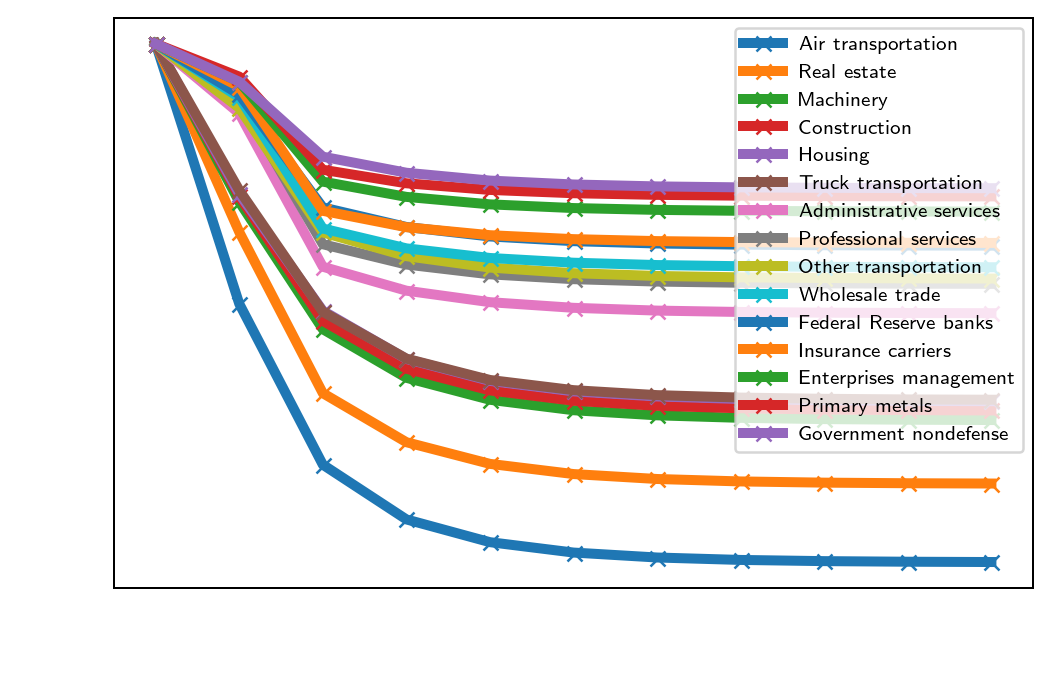

In [16]:
# initial params
year = 2020
u = data.Use(year)
y = u.table.loc["Value Added (producer prices)", :][:data.Table.nInd]
H = data.I2IReqs(year).make_adjacency()
industry_names = H.columns.tolist()
        
# simulate the shock
dz = compute_dz(equity_df=df, window=18, cutoff_pct=-0.2)
all_run = simulator.simulateAll(y=y, H=H, dz=dz)
ar = np.array(all_run)

# look at downstream effects
one_run = simulateOneTime(y=y, H=H, dz=dz)
oar = np.array(one_run)
relative_shocks = pd.DataFrame(oar / oar[0, :])
relative_shocks.columns = industry_names
most_effected = get_min_elements_index(relative_shocks.iloc[-1,:], n=15)
fig = plt.figure()
ax = fig.add_subplot()
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.plot(relative_shocks.iloc[:, most_effected], marker="x")
plt.xlabel("Effect Order")
plt.ylabel("1 - Relative Change of Value Added")
impacted_industries = [x.replace('&', 'and') for x in relative_shocks.columns[most_effected]]
plt.legend(impacted_industries, prop={'size': 8}, loc="upper right")
plt.tight_layout()
#plt.savefig('equity-df.png', dpi=500)
plt.show()

In [8]:
relative_shocks["Real estate"]

0    1.000000
1    0.720628
2    0.668261
3    0.668261
Name: Real estate, dtype: float64

In [48]:
(np.ones(shape=relative_shocks.shape) - relative_shocks.values).sum(axis=1) / relative_shocks.shape[1] * 100

array([0.        , 4.07663392, 7.3182564 , 7.3182564 ])

In [57]:
relative_shocks.columns.tolist()

['Farms',
 'Forestry',
 'Oil & Gas',
 'Mining',
 'Mining activities',
 'Utilities',
 'Construction',
 'Wood',
 'Nonmetallic minerals',
 'Primary metals',
 'Fabricated metals',
 'Machinery',
 'Electronics',
 'Electrical equipments',
 'Motor Vehicles',
 'Transportation equipment',
 'Furnitures',
 'Misc. Manufacturing',
 'Food products',
 'Textile mills',
 'Apparel',
 'Paper',
 'Printing',
 'Petroleum & coal',
 'Chemical products',
 'Plastics & Rubber',
 'Wholesale trade',
 'Vehicle dealers',
 'Food stores',
 'Merchandise stores',
 'Other retail',
 'Air transportation',
 'Rail transportation',
 'Water transportation',
 'Truck transportation',
 'Ground transportation',
 'Pipeline transportation',
 'Other transportation',
 'Warehousing & storage',
 'Publishing industries',
 'Motion picture',
 'Broadcasting',
 'Information services',
 'Federal Reserve banks',
 'Securities',
 'Insurance carriers',
 'Funds & trusts',
 'Housing',
 'Real estate',
 'Rental services',
 'Legal services',
 'Computer

In [72]:
(np.ones(relative_shocks[['Motor Vehicles', 'Utilities', 'Machinery', 'Oil & Gas']].shape) - relative_shocks[['Motor Vehicles', 'Utilities', 'Machinery', 'Oil & Gas']]).sum(axis=1) / 4

0    0.000000
1    0.077718
2    0.117846
3    0.117846
dtype: float64

In [24]:
dz

array([-4.28794179e-02, -9.44842409e-03, -2.49779752e-02,  9.25257620e-02,
       -8.16466348e-03, -1.17697047e-01, -2.20921647e-01, -1.17218461e-02,
       -1.87439553e-02, -2.86376893e-02, -3.04721282e-02, -2.28659635e-01,
       -6.31217538e-03, -1.10034099e-02, -1.60132306e-02, -7.49229233e-03,
       -8.51209991e-03,  2.29365091e-03,  5.66517337e-03,  3.38650579e-02,
       -7.52406363e-03, -2.63748083e-02, -9.18379166e-03, -8.91802637e-02,
       -1.99762715e-01,  1.85833313e-02,  1.12605741e-01, -7.58891399e-03,
       -1.06623901e-02, -7.74927902e-03, -1.99891083e-02, -4.82311797e-01,
       -1.54224430e-01, -1.42567739e-01, -2.21733140e-01, -5.04820629e-03,
       -6.11067760e-03, -8.17266058e-02, -3.59676009e-02, -4.30409536e-03,
       -6.03540576e-03, -4.87034770e-03, -4.20715061e-03, -1.36103178e-02,
       -7.46829565e-03,  3.99411942e-02, -5.64613279e-03, -2.52233845e-01,
       -2.49802914e-01, -9.51666038e-03, -3.98966884e-04, -2.67014686e-03,
        3.19754052e-04, -

# Tzu's dz and dynamics

Here I look at what happens with Tzu's dz vector.


In [38]:
DZ = pd.read_csv('tzu-dz1.csv', header=None)
DZ = DZ.values.ravel()

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


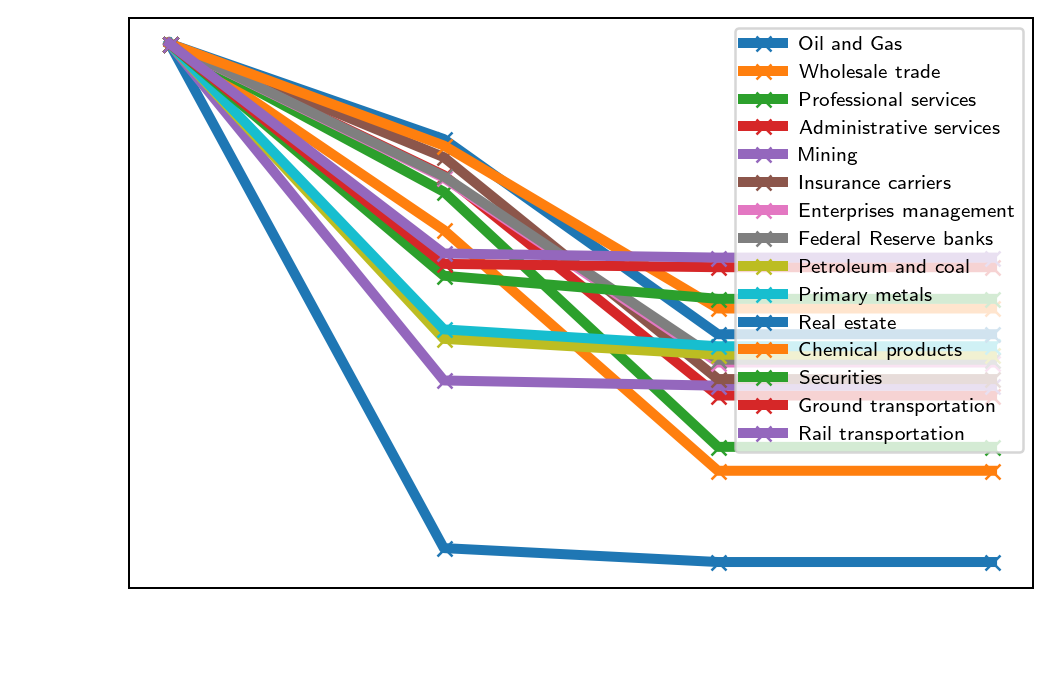

In [73]:
all_run = simulator.simulateAll(y=y, H=H, dz=DZ)
ar = np.array(all_run)

# look at downstream effects
one_run = simulateOneTime(y=y, H=H, dz=DZ)
oar = np.array(one_run)
relative_shocks = pd.DataFrame(oar / oar[0, :])
relative_shocks.columns = industry_names
most_effected = get_min_elements_index(relative_shocks.iloc[-1,:], n=15)
fig = plt.figure()
ax = fig.add_subplot()
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.plot(relative_shocks.iloc[:, most_effected], marker="x")
plt.xlabel("Effect Order", color="white")
plt.ylabel("1 - Relative Change of Value Added", color="white")
impacted_industries = [x.replace('&', 'and') for x in relative_shocks.columns[most_effected]]
plt.legend(impacted_industries, prop={'size': 8}, loc="upper right")
plt.tight_layout()
plt.savefig('tzu-dz.png', dpi=500)
plt.show()

In [46]:
(np.ones(relative_shocks.shape) - relative_shocks).sum(axis=1) / relative_shocks.shape[1] * 100

0    0.000000
1    1.390474
2    2.152317
3    2.152317
dtype: float64

In [74]:
(np.ones(relative_shocks[['Motor Vehicles', 'Utilities', 'Machinery', 'Oil & Gas']].shape) - relative_shocks[['Motor Vehicles', 'Utilities', 'Machinery', 'Oil & Gas']]).sum(axis=1) / 4

0    0.000000
1    0.032401
2    0.038312
3    0.038312
dtype: float64

# Interpolate missing indices with H covariance structure

The idea is that for those industries that do not have equity indices listed, we can interpolate their values based on what industries they are most correlated with in the $H$ matrix. Below we have pseduo analysis that shows stationarity of the $H$ matrix - implying we can somewhat trust the most recent $H$ for this. The idea is that for industry $j$ missing, we can interpolate dz[j] by those industries $i$ with equity indices and estimated dz[i]:

$$dz[j]\leftarrow \sum\limits_{i\neq j} \frac{\text{Cov}(H_i,H_j)}{\sum\limits_{k\neq j} \text{Cov}(H_k,H_j)}dz[i].$$

A inherent weakness of this approach is that dz[j] is bounded between those industries that we know (it can't be greater than or smaller than in size). However this approach is very intuitive and neat in that it captures the shocks to industries that have similar palettes for goods to produce output. I'll do this tonight. 

I want to look at row-wise correlations - that is comparing row $i$ to row $j$ not column $i$ to column $j$. Then doing this, we obtain the following

In [18]:
dz

array([-4.28794179e-02, -9.44842409e-03, -2.49779752e-02,  9.25257620e-02,
       -8.16466348e-03, -1.17697047e-01, -2.20921647e-01, -1.17218461e-02,
       -1.87439553e-02, -2.86376893e-02, -3.04721282e-02, -2.28659635e-01,
       -6.31217538e-03, -1.10034099e-02, -1.60132306e-02, -7.49229233e-03,
       -8.51209991e-03,  2.29365091e-03,  5.66517337e-03,  3.38650579e-02,
       -7.52406363e-03, -2.63748083e-02, -9.18379166e-03, -8.91802637e-02,
       -1.99762715e-01,  1.85833313e-02,  1.12605741e-01, -7.58891399e-03,
       -1.06623901e-02, -7.74927902e-03, -1.99891083e-02, -4.82311797e-01,
       -1.54224430e-01, -1.42567739e-01, -2.21733140e-01, -5.04820629e-03,
       -6.11067760e-03, -8.17266058e-02, -3.59676009e-02, -4.30409536e-03,
       -6.03540576e-03, -4.87034770e-03, -4.20715061e-03, -1.36103178e-02,
       -7.46829565e-03,  3.99411942e-02, -5.64613279e-03, -2.52233845e-01,
       -2.49802914e-01, -9.51666038e-03, -3.98966884e-04, -2.67014686e-03,
        3.19754052e-04, -

# Correlations of H over time - EDA

The below is a simple justification for why choice of $H$ is unimportant in the grand scheme of things.

In [6]:
# look at correlation differences over time - i.e. how steady H is 
H_matrices = [data.I2IReqs(year).make_adjacency() for year in np.arange(1997, 2021)]
corr_matrices = [H.corr() for H in H_matrices]
differences = []
for corr_i, corr_j in combinations(corr_matrices, 2):
    differences.append(corr_i - corr_j)

avg_corr_diff = sum(differences) / len(differences)

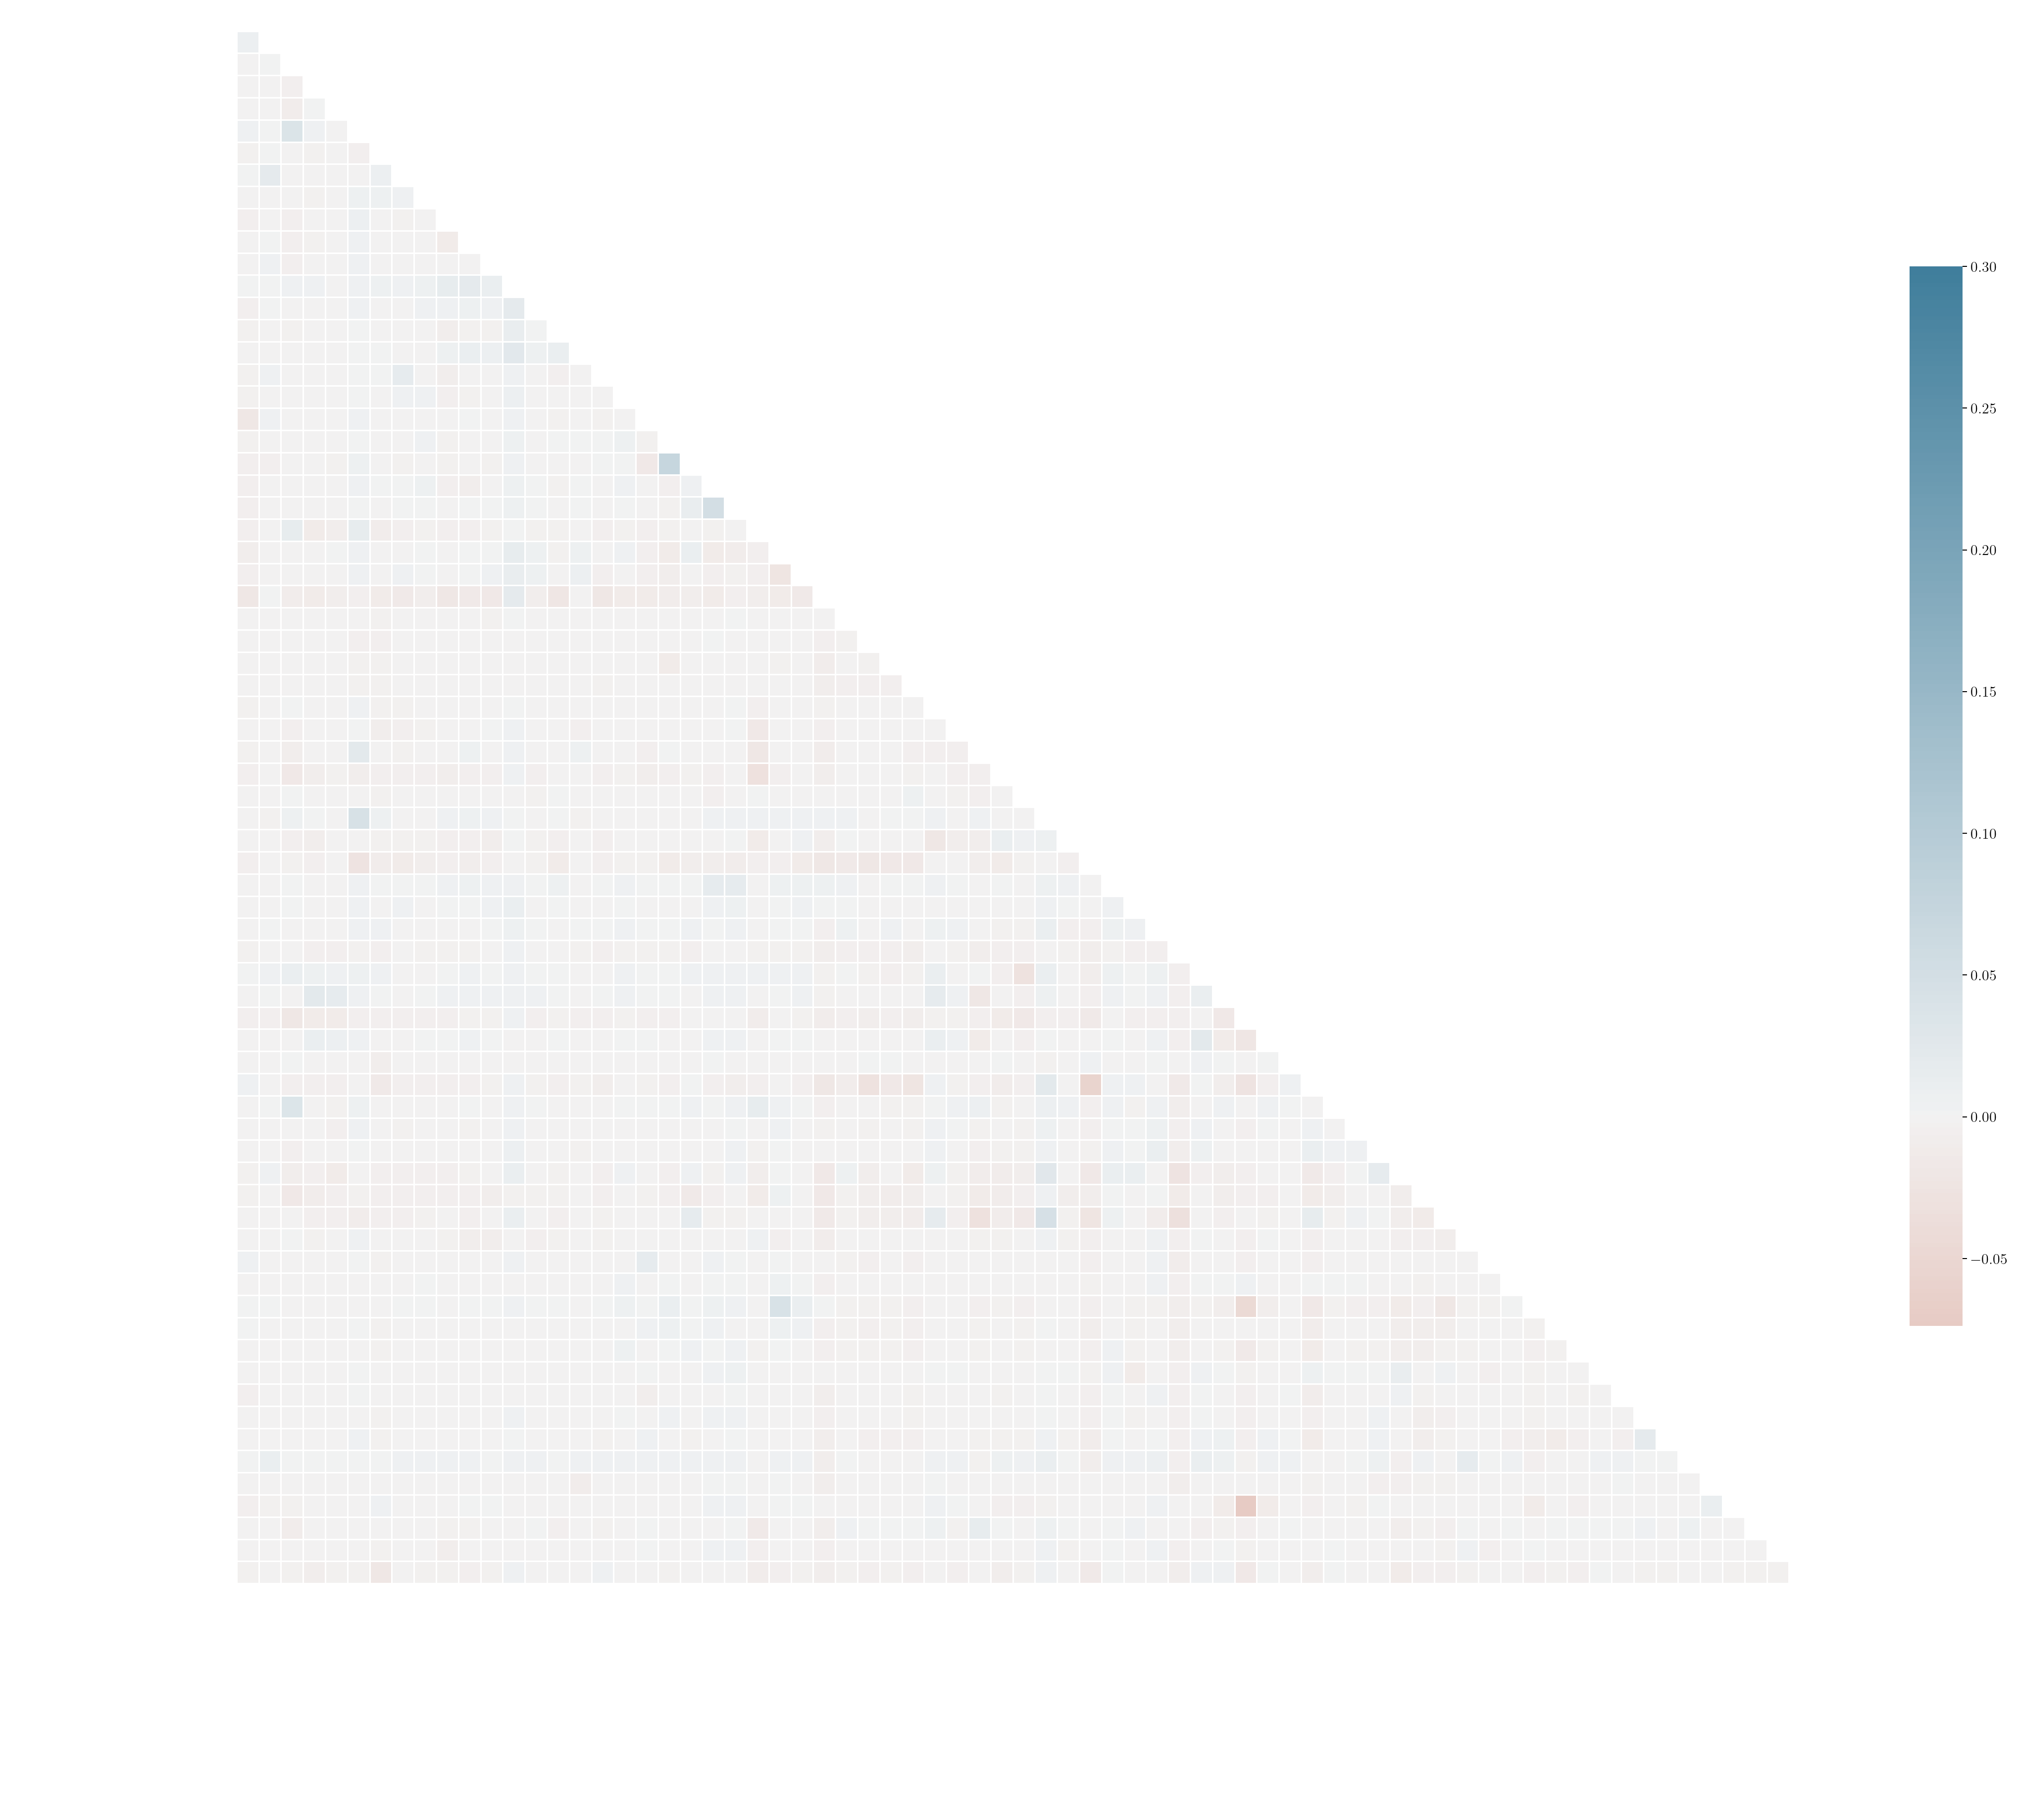

In [9]:
# I have to replace the & with and in the column names here
avg_corr_diff.columns = [x.replace('&', 'and') for x in avg_corr_diff.columns.tolist()]
avg_corr_diff.index = [x.replace('&', 'and') for x in avg_corr_diff.columns.tolist()]

mask = np.triu(np.ones_like(avg_corr_diff, dtype=bool))  
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(25, 25))
fig = sns.heatmap(avg_corr_diff, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xlabel(None)
plt.ylabel(None)
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.tight_layout()
plt.savefig('corr_plot.png')

# Ignore Below - it's scratch work

# Ignore Below

# Ignore Below

# Model Selection and Validation

I think we pick $dz$ based on monthly total value added data. This is the closest to the real thing. From here, I think we pseudo-validate our results by comparing the movement with equities in a hand-wavy fashion. I mean that we can look at autocorrelation structures as we believe price is proportional to output so the series should match to some extent. 

Our work is reduced to the following then:

1) Find equities or futures that align with industry movement - these could be futures instead. This requires a dictionary of sorts - for instance map soybeans futures to farms total value added, .... This is the involved part of the process, but IMO the most sensible. Assignees: Mark and Andrej. Time ~ 1-3hr for 40 industries key-value pairs.

2) Estimate dz with Tzu's method using value added max differences as a proxy for dz. Then with dz estimated, compare it with the dynamics side by side in the equity markets. We could also emulate the changes in Andrew's network as an alternative visualization of changes. Assignees: Tzu, Andrew, maybe Mark/Andrej. Time ~ idk.  

3) Talk about the results - hey we observed this in equities, and now believe our model accurately can emulate dynamics - is this method dumb - we'll discuss on Monday. Assignees:  

# Picking the Right H

We must decide how to correctly pick the H. Candidate options include:

- H from 2019 or 2020 (as these accurately reflect pandemic interactions)

- Average of most recent H (maybe last 5 years weighted)

- H from 2019 or 2020 but hard code in select linkages 

For evaluating H, we discussed one way of statistically validating the result. That is, we take an external dataset to compare this H to but this is insanely difficult and not reasonable as there are 70 something squared entries to validate against, but finding a dataset that does such is nearly impossible. Thus, I think we run through all three of these options, and verify that they agree with intuition and equity price action for instance. Statistics really has no place here with the very small sample size of data we have to try to validate it against.

In [2]:
# option 1 - pick one matrix
H_1 = H_matrices['2019'] 
H_2 = H_matrices['2020']

# option 2 - weighted average
n = 2 

# equal weights
H_3 = (1 / n) * (H_matrices['2019'] + H_matrices['2020'])

# other weights
H_4 = (0.5 / n) * H_matrices['2019'] + ((n - 0.5) / n) * H_matrices['2020']

# option 3 - hardcoding linkages TBD/maybe not...

# Picking the Right dz

Here let's try to quickly develop a makeshift vector that should properly represent the initial onset of the pandemic by analyzing the equity markets. I would in particular like to explore what moved first - how it compares to statistical volatility to determine magnitudes.

## Volatility Spikes as a proxy for pandemic onset and magnitude of dz entries

Justiification for looking at volatility here to determine dz: spikes in volatility were characteristic of the pandemic crisis and for this reason, I believe that we should consequently look at these spikes and their relative ordering to get a sense of what moved first, how much vol, etc.

In [3]:
# large cap equities gathered for each of these industries

# airlines, cars, energy, hotels, restaurants, beauty, tobacco, 
# metal manufacturing, wood manufacturing, utilities, paper, oil/gas
# banking, forestry, telecommunication, healthcare, computer hardware, 
# home furnishing/furniture, educational services, technology

stonks = yf.download(tickers='LUV, FORD, XOM, HST, YUM, ULTA, PM, NUE, WFG, XLU, NP, MPC, JPM, WOOD, VZ, JNJ, ANET, FBHS, CHGG, GOOG', interval = '1d', start = '2019-01-01', end = '2021-01-01')
df = stonks[stonks.index >= datetime(2020, 2, 1)]

[*********************100%***********************]  20 of 20 completed


In [4]:
tickers = sorted(['LUV', 'FORD', 'XOM', 'HST', 'YUM', 'ULTA', 'PM', 'NUE', 'WFG', 'XLU', 'NP', 'MPC', 'JPM', 'WOOD', 'VZ', 'JNJ', 'ANET', 'FBHS', 'CHGG', 'GOOG'])
df = stonks.iloc[:, :len(tickers)].dropna()
df.columns = tickers

<AxesSubplot:xlabel='Date'>

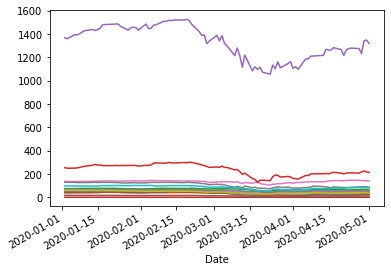

In [5]:
df[(df.index >= datetime(2020, 1, 1)) & (df.index <= datetime(2020, 5, 1))].plot(legend=False)

My first idea is that I take a look at when the Covid Pandemic sparked volatility shocks in the markets and see where the maximum volatility of a given window size occurs for each of the stocks and the magnitude of it compared to the historical volatility - which I'll estimate by means of averaging the same window size over the past two years.

In [6]:
stonks_old = yf.download(tickers='LUV, FORD, XOM, HST, YUM, ULTA, PM, NUE, WFG, XLU, NP, MPC, JPM, WOOD, VZ, JNJ, ANET, FBHS, CHGG, GOOG', interval = '1d', end = '2021-01-01')
df_old = stonks_old.iloc[:, :len(tickers)].dropna()
df_old.columns = tickers

[*********************100%***********************]  20 of 20 completed


In [7]:
window = 10
old_vol_dict = {}
for ticker in tickers:
    x = df_old[ticker]
    volatilities = x.rolling(window).std().dropna()
    mu = np.mean(volatilities)
    sd = np.std(volatilities)
    old_vol_dict[ticker] = [mu, sd]
    
old_vol_dict

{'ANET': [1.2721540676716407, 1.1332358785825531],
 'CHGG': [0.8309410415406171, 1.121897109470372],
 'FBHS': [1.0795332992805775, 0.8743264057356998],
 'FORD': [0.053167904101026696, 0.06934521689949343],
 'GOOG': [17.722261156563174, 13.41234136891033],
 'HST': [0.32295620169090966, 0.20684182886304298],
 'JNJ': [1.4002561514515197, 1.0861451223694027],
 'JPM': [1.4389866887166092, 1.2755094581838662],
 'LUV': [1.0595073287178933, 0.6878531956510668],
 'MPC': [1.1902637973280255, 0.8412078982093295],
 'NP': [1.1321804912421023, 0.7381713290163051],
 'NUE': [1.0065322869153124, 0.5464433856625948],
 'PM': [1.131409860887632, 0.886805067028725],
 'ULTA': [5.548459031192866, 5.397249312271072],
 'VZ': [0.548162738782347, 0.3256856950905521],
 'WFG': [1.3607161426695393, 0.7642106604547692],
 'WOOD': [0.7971844419869052, 0.5858033888785469],
 'XLU': [0.5557111157106438, 0.5211359175113692],
 'XOM': [0.9251745008102439, 0.6235010303492742],
 'YUM': [1.1123861151388803, 1.0193362496383305]

In [8]:
def max_volatility(df, window):
    vol_dict = {}
    for ticker in tickers:
            x = df[ticker]
            volatilities = x.rolling(window).std().dropna()
            max_vol = (np.max(volatilities) - old_vol_dict[ticker][0]) / old_vol_dict[ticker][1]
            idx = np.argmax(volatilities)
            vol_dict[ticker] = [idx, max_vol]
            
    return vol_dict

max_volatility(df[(df.index >= datetime(2020, 1, 1)) & (df.index <= datetime(2020, 5, 1))], 10)

{'ANET': [42, 2.339406666646116],
 'CHGG': [44, 2.8029861426258185],
 'FBHS': [43, 9.183982539819974],
 'FORD': [0, 0.329421427126053],
 'GOOG': [42, 5.991084006795704],
 'HST': [41, 5.740003421012509],
 'JNJ': [46, 6.480658228469184],
 'JPM': [39, 7.7146741633596125],
 'LUV': [45, 5.627000808827658],
 'MPC': [41, 8.439541258416362],
 'NP': [43, 8.206055620976334],
 'NUE': [42, 5.4827374518667655],
 'PM': [46, 6.713629377640093],
 'ULTA': [43, 7.271416975706693],
 'VZ': [42, 5.028500115133282],
 'WFG': [41, 5.64521845765959],
 'WOOD': [42, 9.125787434635996],
 'XLU': [42, 9.500154102361716],
 'XOM': [41, 7.337932307487145],
 'YUM': [46, 9.0343026458038]}

Here I would hypothesize that the index of the max vol shock for equities appears to be meaningless as Arista networks had one of the earlier shocks despite being mild whereas Southwest had a volatility spike $$4*10\approx1.3$$ months later? This doesn't make too much sense to me, but I could be wrong. Maybe a justification I could throw this way is that airlines are a bit upstream and so the shock took travel restrictions which were imposed later to shock that space. That'd be interesting to check out. 

By order of magnitude of the volatility shock, we see the order is given by XLU (utilities large-cap), FBHS (home and security), WOOD (global timber and forestry index), YUM (food and restaurants), MPC (petroleum company), and NP (specialty materials). 

Why is Ford so low though?????? What????? ANET, CHGG, GOOG make sense as tech did decently through the storm. I may add more stocks to this list to make it more complete. My thought process is that I take those occurring before index 44 and combine those into my initial dz and see if that propogates to later hit airlines as we see by the vol spike. If not, then I guess I amass all these ones into one shock and just use the relative magitudes to see the first and second order effects or something...

In [11]:
def volatility_rolling(df, window, idx):
    vol_dict = {}
    for ticker in tickers:
            x = df[ticker]
            volatilities = x.rolling(window).std().dropna()
            vol_dict[ticker] = (volatilities[idx] - old_vol_dict[ticker][0]) / old_vol_dict[ticker][1]
            
    return vol_dict

rolling_vol = volatility_rolling(df[(df.index >= datetime(2020, 1, 1)) & (df.index <= datetime(2020, 5, 1))], 10, 42)

I compute the volatilities of each of the industries at this particular point in time and then use these weightings as schemes to determine the magnitude injected in the dz vector. If volatility is negative as is the case with Ford, I make note of that, but I believe that if historical avg vol is higher, then I should just take that as an indicator that this went relatively unchanged at this point in time.

In [19]:
# scale everything so that I have a max pct drop of 1-exp(-max_drawdown)%
max_drawdown = 0.6
div = np.max(list(rolling_vol.values())) / max_drawdown
pseudo_dz = list(rolling_vol.values()) / div
dz_dict = {key: value for key, value in zip(list(rolling_vol.keys()), pseudo_dz)}
dz_dict

{'ANET': 0.1477496033078797,
 'CHGG': 0.11338892066860859,
 'FBHS': 0.5615786277334858,
 'FORD': -0.03224459173852966,
 'GOOG': 0.37837811527539333,
 'HST': 0.35878437373432975,
 'JNJ': 0.2736102102692547,
 'JPM': 0.4270581889405414,
 'LUV': 0.2562198119376087,
 'MPC': 0.5318200077128596,
 'NP': 0.49443051186053727,
 'NUE': 0.3462725378635976,
 'PM': 0.3462116440946811,
 'ULTA': 0.3971995947766153,
 'VZ': 0.31758432932471325,
 'WFG': 0.340069573252519,
 'WOOD': 0.5763561729404376,
 'XLU': 0.6,
 'XOM': 0.4420561695014834,
 'YUM': 0.4826583163635284}

### How to use this

From here, we simply map these equity names to industries. For instance, YUM gets replaced by restaurants in the industry or commodity list and the XOM related industries are accounted for in terms of energy where I can change that. 

### What to do about industries not included here

I think that for industries that are not included here, it's a very difficult question to be honest. For industries that are very correlated - like primary vs specialty metals, my first thought is to lazily assign both to the same dz vector based on what was said above. Another alternative is to use cross correlations to determine which get placed in the initial dz bin - i.e. if one precedes the other by looking at cross correlations, then it's probably a good idea to not have them initialized as the same. This is painful in workload however. I would like to think of some way to carry out this analysis in an autonomous manner, but I am not entirely sure how to do that. 

This is a supply-side shock, so we can look at total industry or commodity output and look at cross correlations at the origin and multiply unknown industry entries by that correlation - however if it's negative, then I am not sure what to do.

## Price Differences as a proxy for pandemic onset and dz magnitudes

A possibly more sensible option here would be to find the max price drop over some rolling window and compare that to historical averages - i.e. the same thing but replace volatility with price differences or we could just use max difference over some specified window in terms of percentage change and just inject that into the dz vector. 

Akin to the above approach, I can garner a sense of when exactly the pandemic struck individual equities by looking at the max difference over a rolling window and use this as a decider as to what industries I initialize dz with. 

Another though to wonder about is how long this window should be, what time frame I should look over after computing the rolling windows to decide which industries get shocked first, and cross correlations to see if spikes in cross-correlated industries occured not independently, but because one steamrolled through the other as the network should be able to tell us. 

## Basic Background on IO Analysis

Wassily Leontief claimed an economy is divided into sectors and each sector produces its own product. To produce a product, an industry must use other sector products (potentially including itself - think Oil). In pseudo-equation format, we mean that

$$\text{Total Amount Produced} = \text{Total Internal Demand} + \text{Total External Demand.}$$

Let us consider an IO table withe the following toy dynamics:

$$\begin{cases}\text{Lumber Produced} =0.1\times\text{Lumber Produced} + 0.2\times\text{Oil Produced} + 0.2\times\text{Housing Produced} \\ \text{Oil Produced} = 0.15\times\text{Lumber Produced} + 0\times\text{Oil Produced} + 0.4\times\text{Housing Produced} \\ \text{Housing Produced} = 0.12\times\text{Lumber Produced} + 0.3\times\text{Oil Produced} + 0.2\times\text{Housing Produced}\end{cases}$$

or more succinctly, we have in matrix notation that the system can be written as 

$$C=\begin{bmatrix} 0.1 & 0.2 & 0.2 \\ 0.15 & 0 & 0.4 \\ 0.12 & 0.3 & 0.2\end{bmatrix}$$

which is defined as the consumption matrix. This gives us a sense of what products are required to produce one unit of the output which is defined as the rows of the matrix and the columns denote the industries needed by that row to produce a unit. Additionally, we may have products outside of the industry that each row may require to make produce - say $[d_1, d_2, d_3]^T$ (known as **external demand**) so that our total amount produced in this economy is given by the Leontief Input-Output model:

$$\begin{bmatrix}p_1 \\ p_2 \\ p_3\end{bmatrix} = \begin{bmatrix} x_{11} & x_{12} & x_{13} \\ x_{21} & x_{22} & x_{23} \\ x_{31} & x_{32} & x_{33}\end{bmatrix}\begin{bmatrix} p_1 \\ p_2 \\ p_3\end{bmatrix} + \begin{bmatrix} d_1 \\ d_2 \\ d_3\end{bmatrix}$$

or more concisely

$$\hat{p} = C\hat{p} + \hat{d}.$$

Then we rearrange terms to obtain that $(I-C)\hat{p}=\hat{d}$. If we desire to obtain the production vector, then we multiply both sides by the Leontief inverse to obtain that $\hat{p}=(I-C)^{-1}\hat{d}$. If the external demand for industry $1$ changes, we get that

$$\hat{p}=(I-C)^{-1}(\hat{d}+e_1).$$

In our case, we first need to find this matrix $A$ from the IO table data that we have. We can do so by first dividing each row by the total industry output for that particular row and thus obtain values for each entry in that row that corespond to the percentage of that product's use for the industry in between 0 and 1. For now, I assume that this vector $\hat{d}$ can be represented as the sum of the components in the total value added secondary industries. 

# Sources

- https://deliverypdf.ssrn.com/delivery.php?ID=142095081069091010100114080076120113014042095000089091121086081094073011121025006092119034022008009024050126007065100005115031006007037073081010101127093115018122104037082049074086104083126019115004027076089070121007094071117124116087095116120028127123&EXT=pdf&INDEX=TRUE

- Plosser: https://www.jstor.org/stable/pdf/1840430.pdf?refreqid=excelsior%3A1f614c97be9e6b0cf8359bddc9fb295a&ab_segments=&origin=

- Smirnov proof: https://arxiv.org/pdf/1910.06739.pdf

- Meeusen: https://www.jstor.org/stable/pdf/2525757.pdf

- Demirer: https://economics.sas.upenn.edu/system/files/2020-01/Demirer_JMP.pdf

- Antras harvard: https://dash.harvard.edu/bitstream/handle/1/3196325/antras_usaggregate.pdf

- io tables for dummies: https://www.uvm.edu/~wgibson/CYU/CYU_InputOutput.pdf